# Определение стоимости автомобилей

<a name="1"></a>
## Содержание

[1. Содержание](#1)

[2. Описание проекта](#2)

*    [2.1. Цель проекта](#21)
*    [2.2. Задачи проекта](#22)
*    [2.3. Описание данных](#23)
*    [2.4. План работы](#24)

[3. Исследование данных](#3)

*    [3.1. Изучение данных](#31)
*    [3.2. Удаление признаков](#32)
*    [3.3. Исследование данных после первичной предобработки](#33)
*    [3.4. Обработка аномалий](#34)
*    [3.5. Обработка пропусков](#35)
*    [3.6. Исследование данных после итоговой предобработки](#36)
*    [3.7. Вывод](#37)

[4. Подготовка данных к обучению](#4)

*    [4.1. Разделение данных на выборки](#41)
*    [4.2. Кодирование категориальных признаков](#42)
*    [4.3. Масштабирование численных признаков](#43)

   *    [4.3.1. Для моделей `LGBMRegressor` и `RandomForestRegressor`](#431)
   *    [4.3.2. Для модели `CatBoostRegressor`](#432)
        
*    [4.4. Вывод](#44)

[5. Обучение моделей](#5)

*    [5.1. `RandomForestRegressor` + `GridSearchCV`](#51)
*    [5.2. `LGBMRegressor`](#52)
*    [5.3. `LGBMRegressor` + `GridSearchCV`](#53)
*    [5.4. `CatBoostRegressor`](#54)
*    [5.5. `CatBoostRegressor` + `GridSearchCV`](#55)
*    [5.6. Вывод](#56)

[6. Анализ моделей](#6)

*    [6.1. Сравнение моделей](#61)
*    [6.2. Тестирование лучшей модели](#62)
*    [6.3. Итоговое сравнение моделей](#63)
*    [6.4. Вывод](#64)

[7. Общий вывод](#7)

## Описание проекта
<a name="2"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Нам нужно построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:

- качество предсказания;
- время обучения модели;
- время предсказания модели.

### Цель проекта
<a name="21"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Провести исследование с целью построения модели машинного обучения, которая поможет определить рыночную стоимость автомобиля.

Результаты исследования позволят сервису по продаже автомобилей разработать приложение для привлечения новых клиентов.

### Задачи проекта
<a name="22"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

1. Исследовать данные.
2. Построить и обучить модели.
3. Проанализировать модели.
4. Протестировать лучшую модель.
5. Написать общий вывод.

Значение метрики *RMSE* должно быть меньше 2500.

### Описание данных
<a name="23"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Файл датасета - `autos.csv`.

### План работы
<a name="24"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

1. Загрузим данные.
2. Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.
3. Подготовим выборки для обучения моделей.
4. Обучим разные модели, одна из которых — *LightGBM*, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
5. Проанализируем время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.




**Инструкция по выполнению проекта**

Чтобы усилить исследование, не будем ограничиваться градиентным бустингом. 

Попробуем более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.

Поэкспериментируем и сравним характеристики моделей: время обучения, время предсказания, точность результата.


**Примечания**:

- Для оценки качества моделей применим метрику *RMSE*.
- Значение метрики *RMSE* должно быть меньше *2500*.
- Самостоятельно освоим библиотеку *LightGBM* и её средствами построим модели градиентного бустинга.
- Время выполнения ячейки кода *Jupyter Notebook* можно получить специальной командой. Найдём её.
- Модель градиентного бустинга может долго обучаться, поэтому изменим у неё только два-три параметра.
- Если перестанет работать *Jupyter Notebook*, удалим лишние переменные оператором `del`.
```
del features_train
```

## Исследование данных
<a name="3"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import os

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from random import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

RANDOM_STATE = 12345

### Изучение данных
<a name="31"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Загрузим данные.

In [2]:
pth1 = r'C:/Users/Васильев/Desktop/dataframes/autos.csv'
pth2 = '/datasets/autos.csv'
pth3 = '/autos.csv'
pth4 = 'https://code.s3.yandex.net/datasets/autos.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
elif os.path.exists(pth3):
    data = pd.read_csv(pth3)
elif os.path.exists(pth4):
    data = pd.read_csv(pth4)
else:
    print('Something is wrong')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.shape

(354369, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Проверим датасет на наличие явных дубликатов и удалим их.

In [6]:
print(data.duplicated().sum())
data = data.drop_duplicates()
print(data.shape)

4
(354365, 16)


### Удаление признаков
<a name="32"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Имеется 6 неинформативных для модели признаков: 
- `DateCrawled` - дата скачивания анкеты из базы, 
- `RegistrationMonth` - месяц регистрации автомобиля,
- `DateCreated` - дата создания анкеты,
- `NumberOfPictures` - количество фотографий автомобиля,
- `PostalCode` - почтовый индекс владельца анкеты (пользователя),
- `LastSeen` - дата последней активности пользователя.

Удалим данные признаки, т.к. они не пригодятся для дальнейшего исследования.

In [7]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 
                  'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Типы данных соответствуют значениям в признаках.

### Исследование данных после первичной предобработки
<a name="33"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Посмотрим описание численных данных.

In [9]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


При помощи гистограмм визуализируем распределение переменных в датасете.

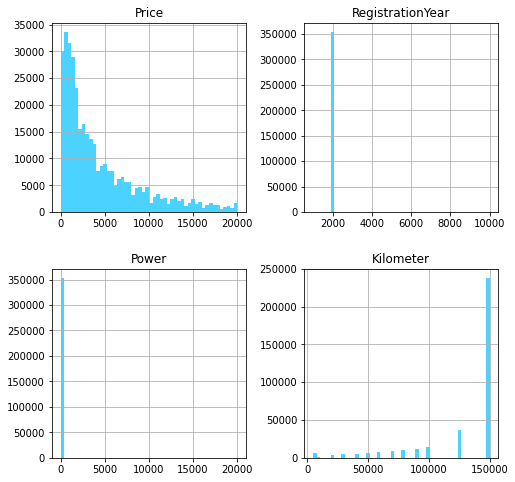

In [10]:
data.hist(figsize=(8, 8), bins=50, alpha=0.7, color='deepskyblue')
plt.show()

Аномалиями здесь можно считать неправдоподобные значения:

- года регистрации; 
- мощности автомобилей;
- нулевые значения признаков.

Построим диаграммы размаха («ящик с усами»), по распределению численных данных при помощи метода `.boxplot()`.

Особенности этой диаграммы:

«Ящик» ограничен первым и третьим квартилями (нижняя и верхняя стороны прямоугольника - границы ящика). Внутри ящика зелёной линией обозначена медиана (второй квартиль).
«Усы» простираются вниз и вверх от границ ящика (чёрные линии ниже и выше границ ящика) на расстояние, равное 1,5 межквартильного размаха (сокращённо *IQR*, от англ. *interquartile range*, «межквартильный размах»). В размах «усов» попадают нормальные значения, а за пределами находятся выбросы, изображённые точками. Если верхний «ус» длиннее максимума, то он заканчивается максимумом. То же - для минимума и нижнего «уса».

**1. Диаграмма размаха по распределению цены автомобиля (с выбросами).**

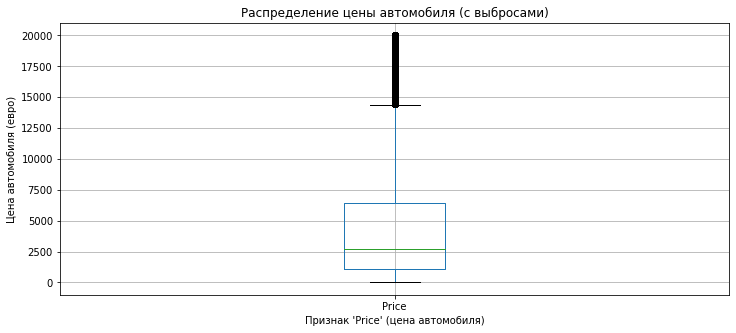

In [11]:
data.boxplot(column='Price', figsize=(12, 5))
plt.xlabel("Признак 'Price' (цена автомобиля)")
plt.ylabel('Цена автомобиля (евро)')
plt.title('Распределение цены автомобиля (с выбросами)')
plt.show()

**2. Диаграмма размаха по распределению года регистрации автомобиля (с выбросами).**

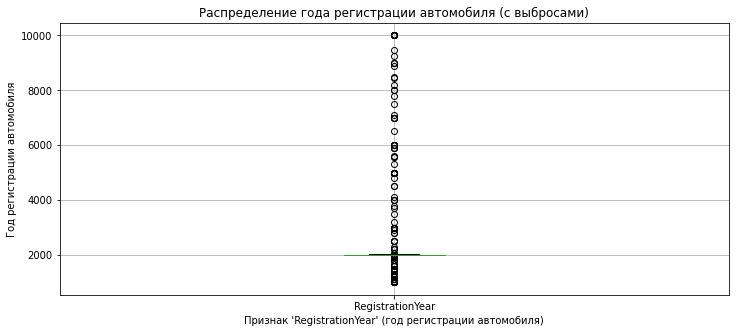

In [12]:
data.boxplot(column='RegistrationYear', figsize=(12, 5))
plt.xlabel("Признак 'RegistrationYear' (год регистрации автомобиля)")
plt.ylabel('Год регистрации автомобиля')
plt.title('Распределение года регистрации автомобиля (с выбросами)')
plt.show()

**3. Диаграмма размаха по распределению мощности автомобиля (с выбросами).**

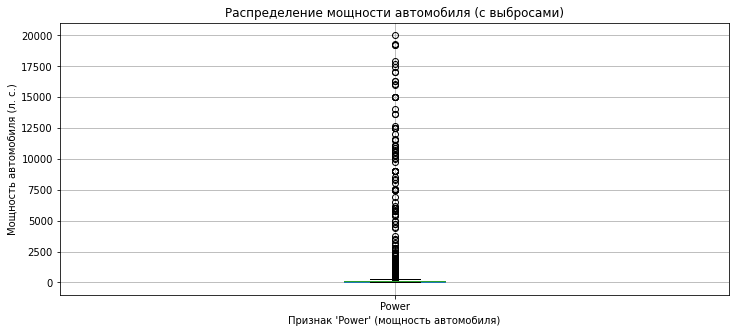

In [13]:
data.boxplot(column='Power', figsize=(12, 5))
plt.xlabel("Признак 'Power' (мощность автомобиля)")
plt.ylabel('Мощность автомобиля (л. с.)')
plt.title('Распределение мощности автомобиля (с выбросами)')
plt.show()

**4. Диаграмма размаха по распределению пробега автомобиля (с выбросами).**

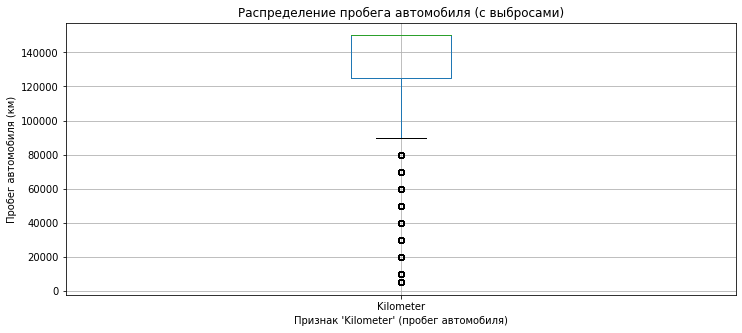

In [14]:
data.boxplot(column='Kilometer', figsize=(12, 5))
plt.xlabel("Признак 'Kilometer' (пробег автомобиля)")
plt.ylabel('Пробег автомобиля (км)')
plt.title('Распределение пробега автомобиля (с выбросами)')
plt.show()

Из-за выбросов, рассмотреть распределение внутри ящиков становится сложно. Поэтому сделаем графики без выбросов, указав параметр `showfliers=False`.

**5. Диаграмма размаха по распределению цены автомобиля (без выбросов).**

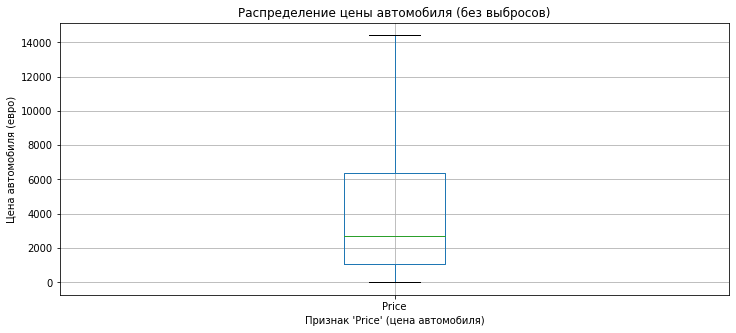

In [15]:
data.boxplot(column='Price', showfliers=False, figsize=(12, 5))
plt.xlabel("Признак 'Price' (цена автомобиля)")
plt.ylabel('Цена автомобиля (евро)')
plt.title('Распределение цены автомобиля (без выбросов)')
plt.show()

**6. Диаграмма размаха по распределению года регистрации автомобиля (без выбросов).**

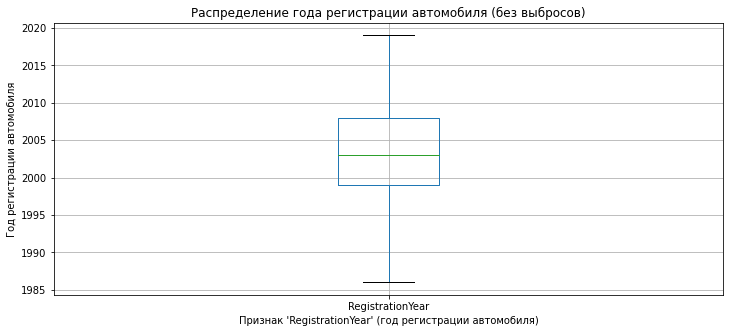

In [16]:
data.boxplot(column='RegistrationYear', showfliers=False, figsize=(12, 5))
plt.xlabel("Признак 'RegistrationYear' (год регистрации автомобиля)")
plt.ylabel('Год регистрации автомобиля')
plt.title('Распределение года регистрации автомобиля (без выбросов)')
plt.show()

**7. Диаграмма размаха по распределению мощности автомобиля (без выбросов).**

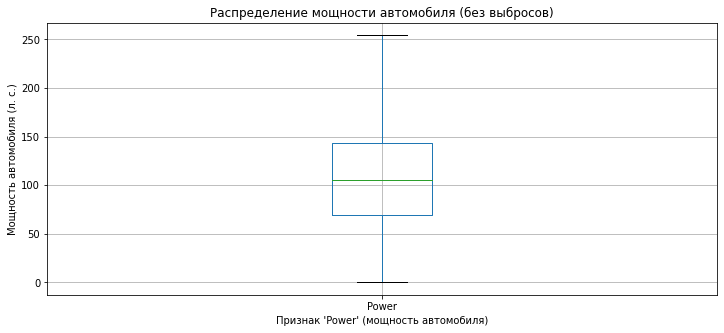

In [17]:
data.boxplot(column='Power', showfliers=False, figsize=(12, 5))
plt.xlabel("Признак 'Power' (мощность автомобиля)")
plt.ylabel('Мощность автомобиля (л. с.)')
plt.title('Распределение мощности автомобиля (без выбросов)')
plt.show()

**8. Диаграмма размаха по распределению пробега автомобиля (без выбросов).**

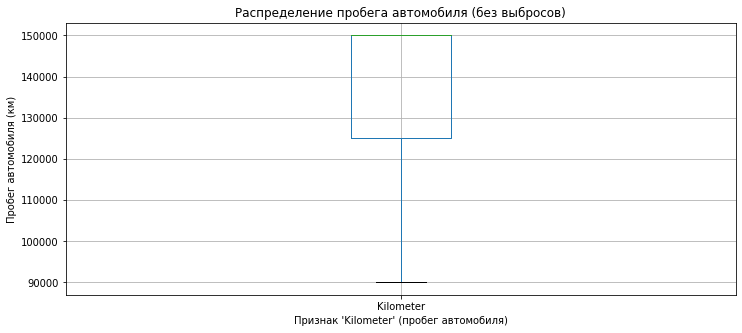

In [18]:
data.boxplot(column='Kilometer', showfliers=False, figsize=(12, 5))
plt.xlabel("Признак 'Kilometer' (пробег автомобиля)")
plt.ylabel('Пробег автомобиля (км)')
plt.title('Распределение пробега автомобиля (без выбросов)')
plt.show()

У признака `Kilometer` получается интересная ситуация: у него медиана и 75%-ый квартиль равны максимальному значению данных.

Очевидно, что выбросы в признаках `RegistrationYear` и `Power` необходимо корректировать.

Выведем коэффициенты корреляции Пирсона для переменных датасета.

In [19]:
data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.026916,0.158872,-0.333207
RegistrationYear,0.026916,1.000000,-0.000828,-0.053448
Power,0.158872,-0.000828,1.000000,0.024006
Kilometer,-0.333207,-0.053448,0.024006,1.000000


Построим тепловую карту коэффициентов корреляции Пирсона для переменных датасета.

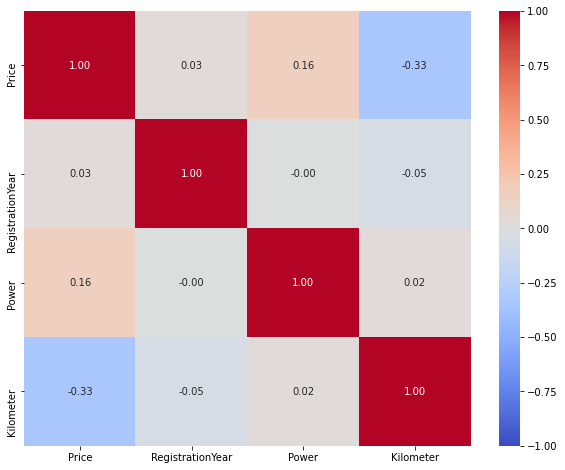

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(
    data.corr(), annot=True, fmt = '.2f', 
    vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.show()

Виднеется незначительная обратная корреляция между признаками `Kilometer` и `Price`, что логично - чем больше пробег, тем ниже цена.

### Обработка аномалий
<a name="34"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Взглянем на состав численных признаков `Price`, `RegistrationYear`, `Power` и `Kilometer`.

In [21]:
data[['Price', 'RegistrationYear', 'Power', 'Kilometer']].describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Здесь аномалиями можно считать неправдоподобные значения года регистрации автомобилей и нулевые значения признаков.

Давайте посмотрим выборочно количество уникальных значений в признаках.

In [22]:
print(len(data['RegistrationYear'].unique()))
print(len(data['Model'].unique()))
print(len(data['Brand'].unique()))

151
251
40


Посмотрим на содержание признаков `DateCrawled`, `RegistrationYear` и `DateCreated`.

In [23]:
try:
    display(pd.read_csv(r'C:/Users/Васильев/Desktop/dataframes/autos.csv')[
        ['DateCrawled', 'RegistrationYear', 'DateCreated']])
except:
    try:
        display(pd.read_csv('/datasets/autos.csv')[
            ['DateCrawled', 'RegistrationYear', 'DateCreated']])
    except:
        try:
            display(pd.read_csv('/autos.csv')[
                ['DateCrawled', 'RegistrationYear', 'DateCreated']])
        except:
            display(pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')[
                ['DateCrawled', 'RegistrationYear', 'DateCreated']])

,DateCrawled,RegistrationYear,DateCreated
0,2016-03-24 11:52:17,1993,2016-03-24 00:00:00
1,2016-03-24 10:58:45,2011,2016-03-24 00:00:00
2,2016-03-14 12:52:21,2004,2016-03-14 00:00:00
3,2016-03-17 16:54:04,2001,2016-03-17 00:00:00
4,2016-03-31 17:25:20,2008,2016-03-31 00:00:00
...,...,...,...
354364,2016-03-21 09:50:58,2005,2016-03-21 00:00:00
354365,2016-03-14 17:48:27,2005,2016-03-14 00:00:00
354366,2016-03-05 19:56:21,2000,2016-03-05 00:00:00
354367,2016-03-19 18:57:12,1996,2016-03-19 00:00:00


Даты скачивания и создания анкеты приходятся на 2016 год. Поэтому, нам нужно удалить все строки, в которых автомобили были зарегистрированы позднее 2016 года.

Сохраним в датасете только те автомобили, год регистрации которых не позже 2016 года, и при этом не раньше 1940 года.

In [24]:
data = data[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] >= 1940)]
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Ещё раз посмотрим количество уникальных значений в признаках.

In [25]:
print(len(data['RegistrationYear'].unique()))
print(len(data['Model'].unique()))
print(len(data['Brand'].unique()))

77
251
40


После удаления нами аномалий, количество уникальных значений в признаке `RegistrationYear` уменьшилось. При этом, количество уникальных значений в признаке `Model` не изменилось. Это означает, что мы сохранили в датасете все возможные модели автомобилей, включая ретро автомобили.

Удалим нулевые значения в признаке `Price`, поставим ограничение на значения в `Power`, затем сбросим индекс в датасете.

In [26]:
data = data[data['Price'] != 0]
data = data[data['Power'] <= 1500]
data = data.reset_index(drop=True)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
329479,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
329480,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
329481,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
329482,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Посмотрим количество нулевых значений в признаке `Power`.

In [27]:
data[data['Power'] == 0].shape

(32794, 10)

Заменим нулевые значения в признаке `Power` на медиану по бренду.

In [28]:
data.loc[data['Power'] == 0, 'Power'] = np.NaN
data['Power'] = data['Power'].fillna(
    data.groupby('Brand')['Power'].transform(
        lambda x: x.median() if x.median() else np.nan))
data[data['Power'] == 0].shape

(0, 10)

Теперь повторно посмотрим количество уникальных значений в признаках.

In [29]:
print(len(data['RegistrationYear'].unique()))
print(len(data['Model'].unique()))
print(len(data['Brand'].unique()))

77
251
40


После удаления нулевых значений, количество уникальных значений в признаках `RegistrationYear` и `Model` не изменилось.

In [30]:
data[['Price', 'RegistrationYear', 'Power', 'Kilometer']].describe()

,Price,RegistrationYear,Power,Kilometer
count,329484.000000,329484.000000,329484.000000,329484.000000
mean,4607.664491,2002.620088,120.140456,128231.067366
std,4546.198371,6.771335,55.971133,37486.631643
min,1.000000,1940.000000,1.000000,5000.000000
25%,1200.000000,1999.000000,80.000000,125000.000000
50%,2900.000000,2003.000000,109.000000,150000.000000
75%,6600.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,1500.000000,150000.000000


### Обработка пропусков
<a name="35"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Модель градиентного бустинга *Catboost* имеет один нюанс - она не распознаёт тип данных `NaN`. 

Поэтому, для её применения в датасете необходимо заполнить пропуски.

Пропуски имеются у следующих признаков:
- `VehicleType` - тип автомобильного кузова;
- `Gearbox` - тип коробки передач;
- `Model` - модель автомобиля;
- `FuelType` - тип топлива;
- `Repaired` - была машина в ремонте или нет.

In [31]:
data.isna().sum()

Price                   0
VehicleType         19884
RegistrationYear        0
Gearbox             15542
Power                   0
Model               15573
Kilometer               0
FuelType            24099
Brand                   0
Repaired            59751
dtype: int64

Посмотрим на состав признаков с пропусками.

In [32]:
data['VehicleType'].value_counts()

sedan          89334
small          77970
wagon          63652
bus            28328
convertible    19846
coupe          15621
suv            11784
other           3065
Name: VehicleType, dtype: int64

In [33]:
data['Gearbox'].value_counts()

manual    250987
auto       62955
Name: Gearbox, dtype: int64

In [34]:
data['Model'].value_counts()

golf                  26723
other                 23142
3er                   18663
polo                  12023
corsa                 11586
                      ...  
kalina                    6
serie_3                   3
rangerover                3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64

In [35]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda',
       'up', 'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira',
       'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1',
       'rio', 'to

In [36]:
data['FuelType'].value_counts()

petrol      204561
gasoline     94803
lpg           5021
cng            531
hybrid         220
other          162
electric        87
Name: FuelType, dtype: int64

In [37]:
data['Repaired'].value_counts()

no     236809
yes     32924
Name: Repaired, dtype: int64

У признаков `VehicleType`, `Model` и `FuelType` одним из значений является "other", поэтому мы заменим пропуски в данных признаках на дополнительную категорию "another".

In [38]:
data['VehicleType'] = data['VehicleType'].fillna('another')
data['Model'] = data['Model'].fillna('another')
data['FuelType'] = data['FuelType'].fillna('another')
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,another,1993,manual,101.0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190.0,another,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
329479,1150,bus,2000,manual,101.0,zafira,150000,petrol,opel,no
329480,2200,another,2005,NaN,140.0,another,20000,another,sonstige_autos,NaN
329481,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
329482,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


Категориальные признаки `Gearbox` и `Repaired` принимают только два значения, т.е. являются бинарными. Для работы модели необходимы численные признаки, поэтому мы можем соответственно преобразовать значения этих признаков в числа "0" и "1".

Для начала, заполним пропуски в признаках `Gearbox` и `Repaired` случайными числами "0" или "1". Для этого применим функцию `randint()`, которая генерирует целые случайные числа в заданном диапазоне.

In [39]:
data['Gearbox'] = data['Gearbox'].fillna(pd.Series(
    np.random.randint(0, 2, size=len(data)), index=data.index))
data['Repaired'] = data['Repaired'].fillna(pd.Series(
    np.random.randint(0, 2, size=len(data)), index=data.index))

print(data['Gearbox'].unique())
print(data['Repaired'].unique())
display(data)

['manual' 'auto' 0 1]
[0 'yes' 1 'no']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,another,1993,manual,101.0,golf,150000,petrol,volkswagen,0
1,18300,coupe,2011,manual,190.0,another,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,1
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
329479,1150,bus,2000,manual,101.0,zafira,150000,petrol,opel,no
329480,2200,another,2005,0,140.0,another,20000,another,sonstige_autos,0
329481,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
329482,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


Проверим наш датасет на наличие пропусков:

In [40]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Затем давайте преобразуем исходные категориальные значения признаков `Gearbox` и `Repaired` в числа "0" и "1".

Для признака `Gearbox` обозначим:
- "0" - для "manual" т.е. ручная кпп,
- "1" - для "auto"  т.е. автоматическая кпп.

Для признака `Repaired` обозначим:
- "0" - для "no" т.е. не был в ремонте,
- "1" - для "yes" т.е. был в ремонте.

In [41]:
data.loc[data['Gearbox'] == 'manual', 'Gearbox'] = 0
data.loc[data['Gearbox'] == 'auto', 'Gearbox'] = 1

data.loc[data['Repaired'] == 'no', 'Repaired'] = 0
data.loc[data['Repaired'] == 'yes', 'Repaired'] = 1

display(data)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,another,1993,0,101.0,golf,150000,petrol,volkswagen,0
1,18300,coupe,2011,0,190.0,another,125000,gasoline,audi,1
2,9800,suv,2004,1,163.0,grand,125000,gasoline,jeep,1
3,1500,small,2001,0,75.0,golf,150000,petrol,volkswagen,0
4,3600,small,2008,0,69.0,fabia,90000,gasoline,skoda,0
...,...,...,...,...,...,...,...,...,...,...
329479,1150,bus,2000,0,101.0,zafira,150000,petrol,opel,0
329480,2200,another,2005,0,140.0,another,20000,another,sonstige_autos,0
329481,1199,convertible,2000,1,101.0,fortwo,125000,petrol,smart,0
329482,9200,bus,1996,0,102.0,transporter,150000,gasoline,volkswagen,0


Преобразуем тип данных у признаков `Gearbox` и `Repaired` в `integer64`:

In [42]:
data['Gearbox'] = data['Gearbox'].astype('int64')
data['Repaired'] = data['Repaired'].astype('int64')

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329484 entries, 0 to 329483
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             329484 non-null  int64  
 1   VehicleType       329484 non-null  object 
 2   RegistrationYear  329484 non-null  int64  
 3   Gearbox           329484 non-null  int64  
 4   Power             329484 non-null  float64
 5   Model             329484 non-null  object 
 6   Kilometer         329484 non-null  int64  
 7   FuelType          329484 non-null  object 
 8   Brand             329484 non-null  object 
 9   Repaired          329484 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 25.1+ MB


Сейчас, наши данные `data` подготовлены для обучения модели градиентного бустинга *Catboost*.

### Исследование данных после итоговой предобработки
<a name="36"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Взглянем на описание данных в итоговом датасете `data`.

In [44]:
data.describe()

,Price,RegistrationYear,Gearbox,Power,Kilometer,Repaired
count,329484.000000,329484.000000,329484.000000,329484.000000,329484.000000,329484.000000
mean,4607.664491,2002.620088,0.214608,120.140456,128231.067366,0.190880
std,4546.198371,6.771335,0.410551,55.971133,37486.631643,0.392996
min,1.000000,1940.000000,0.000000,1.000000,5000.000000,0.000000
25%,1200.000000,1999.000000,0.000000,80.000000,125000.000000,0.000000
50%,2900.000000,2003.000000,0.000000,109.000000,150000.000000,0.000000
75%,6600.000000,2007.000000,0.000000,150.000000,150000.000000,0.000000
max,20000.000000,2016.000000,1.000000,1500.000000,150000.000000,1.000000


Визуализируем при помощи гистограмм распределение переменных в итоговом датасете `data`.

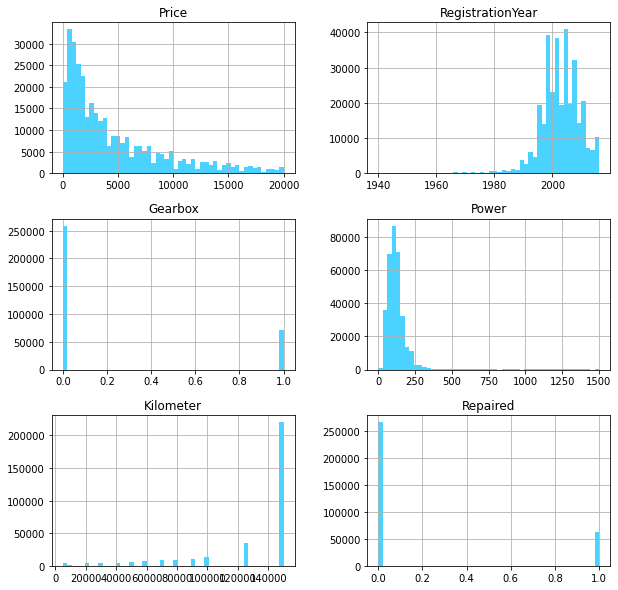

In [45]:
data.hist(figsize=(10, 10), bins=50, alpha=0.7, color='deepskyblue')
plt.show()

Для переменных итогового датасета `data`, выведем коэффициенты корреляции Пирсона.

In [46]:
data.corr()

,Price,RegistrationYear,Gearbox,Power,Kilometer,Repaired
Price,1.000000,0.447416,0.224156,0.459619,-0.354344,-0.234556
RegistrationYear,0.447416,1.000000,0.030648,0.113172,-0.231562,-0.115262
Gearbox,0.224156,0.030648,1.000000,0.361016,0.008496,-0.012362
Power,0.459619,0.113172,0.361016,1.000000,0.091374,-0.063181
Kilometer,-0.354344,-0.231562,0.008496,0.091374,1.000000,0.077585
Repaired,-0.234556,-0.115262,-0.012362,-0.063181,0.077585,1.000000


Построим тепловую карту коэффициентов корреляции Пирсона, для переменных датасета `data`.

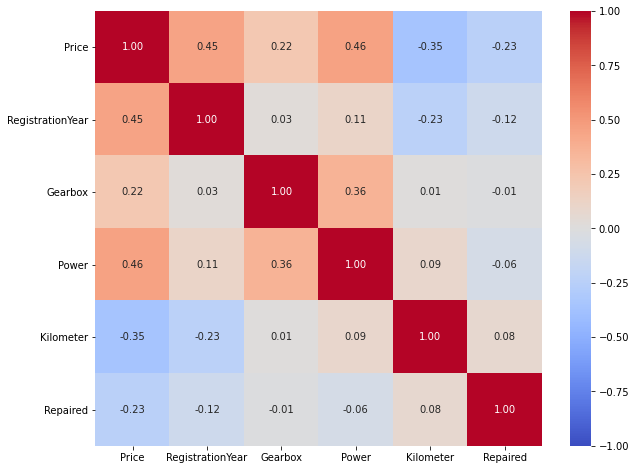

In [47]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, fmt = '.2f', 
            vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.show()

Видно, что имеются незначительная прямая корреляция между признаками `RegistrationYear`, `Power` и `Price`, а также обратная корреляция между признаками `Kilometer` и `Price`, что логично. Так как чем новее автомобиль и больше мощность, тем выше цена. И, наоборот, чем больше пробег, тем ниже цена.

### Вывод
<a name="37"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

В разделе [**Исследование данных**](#3.-Исследование-данных) были выполнены следующие задачи:
1. Изучены данные.
2. Удалены явные дубликаты.
3. Удалены неинформативные признаки.
4. Проведено исследование данных после первичной предобработки.
5. Выполнена обработка аномалий.
6. Выполнена обработка пропусков.
7. Проведено исследование данных после итоговой предобработки.


В результате выполнения задач этого раздела было выявлено следующее:
- Наблюдаются корреляции - незначительная прямая между признаками `RegistrationYear`, `Power` и `Price`, а также обратная между признаками `Kilometer` и `Price`, что логично, поскольку чем новее автомобиль и больше мощность, тем выше цена. И наоборот, чем больше пробег, тем ниже цена.
- Распределения значений признаков стали более правдоподобными.

**В нашем проекте решается задача регрессии.**

## Подготовка данных к обучению
<a name="4"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

### Разделение данных на выборки
<a name="41"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Подготовим выборки из датасета `data`, с заполненными пропущенными значениями.

Разобьём данные, выделим целевой признак.

In [48]:
features = data.drop('Price', axis=1)
target = data['Price']

Разделим данные на обучающую, валидационную а также тестовую выборки, в пропорции 3:1:1.

Сначала разделим полученые данные на промежуточную (`train_valid`) (80%) и тестовую (20%) выборки.

In [49]:
features_train_valid, features_test,\
target_train_valid, target_test = train_test_split(
    features, target, test_size=0.20, random_state=RANDOM_STATE)

Затем разделим нашу промежуточную выборку (`train_valid`) на обучающую и валидационную (25% от промежуточной выборки = 20% от исходного датасета).

In [50]:
features_train, features_valid,\
target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, 
    test_size=0.25, random_state=RANDOM_STATE)

Теперь сбросим индексы, это понадобится нам для последующего кодирования.

In [51]:
features_train = features_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)

features_train_valid = features_train_valid.reset_index(drop=True)
target_train_valid = target_train_valid.reset_index(drop=True)

features_valid = features_valid.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)

features_test = features_test.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

### Кодирование категориальных признаков
<a name="42"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Модели градиентного бустинга `LGBMRegressor` и случайного леса `RandomForestRegressor` имеют нюанс - они не распознают тип данных `object`. Поэтому для их применения необходимо преобразовать категориальные признаки в численные.

Давайте посмотрим, какие категориальные признаки нужно преобразовать в численные.

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329484 entries, 0 to 329483
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             329484 non-null  int64  
 1   VehicleType       329484 non-null  object 
 2   RegistrationYear  329484 non-null  int64  
 3   Gearbox           329484 non-null  int64  
 4   Power             329484 non-null  float64
 5   Model             329484 non-null  object 
 6   Kilometer         329484 non-null  int64  
 7   FuelType          329484 non-null  object 
 8   Brand             329484 non-null  object 
 9   Repaired          329484 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 25.1+ MB


Судя по всему, в численные нужно преобразовать признаки `VehicleType`, `Model`, `FuelType` и `Brand`.

Преобразуем категориальные признаки в численные, используя технику порядкового кодирования *(Ordinal Encoding)*. Для этого мы применим к данным функцию `OrdinalEncoder()`.

Также, сохраним список категориальных признаков в переменной `categorical`.

In [53]:
categorical = ['VehicleType', 'Model', 'FuelType', 'Brand']

In [54]:
# создадим копии выборок для последующего кодирования категориальных признаков
features_train_encoded = features_train.copy()
features_train_valid_encoded = features_train_valid.copy()
features_valid_encoded = features_valid.copy()
features_test_encoded = features_test.copy()

# создадим объект класса OrdinalEncoder()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 

# получим список категориальных признаков используя метод fit() 
# и преобразуем данные на обучающей выборке используя transform()
features_train_encoded[categorical] = encoder.fit_transform(
    features_train_encoded[categorical])

# преобразуем данные на промежуточной выборке
features_train_valid_encoded[categorical] = encoder.transform(
    features_train_valid_encoded[categorical])

# преобразуем данные на валидационной выборке
features_valid_encoded[categorical] = encoder.transform(
    features_valid_encoded[categorical])

# преобразуем данные на тестовой выборке
features_test_encoded[categorical] = encoder.transform(
    features_test_encoded[categorical])

display("Выборка 'train'", features_train_encoded.head())
display("Выборка 'train_valid'", features_train_valid_encoded.head())
display("Выборка 'valid'", features_valid_encoded.head())
display("Выборка 'test'", features_test_encoded.head())

"Выборка 'train'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,1.0,2007,0,131.0,225.0,20000,3.0,38.0,0
1,8.0,2000,0,118.0,11.0,150000,7.0,2.0,0
2,6.0,2006,0,54.0,108.0,90000,7.0,38.0,0
3,0.0,1995,0,150.0,167.0,150000,0.0,20.0,1
4,6.0,2002,0,58.0,84.0,125000,7.0,24.0,0


"Выборка 'train_valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,5.0,2008,0,344.0,141.0,125000,7.0,30.0,0
1,2.0,1997,1,193.0,209.0,80000,7.0,20.0,0
2,5.0,2006,0,177.0,15.0,150000,7.0,2.0,0
3,6.0,2001,0,101.0,129.0,150000,0.0,10.0,0
4,6.0,2000,0,75.0,40.0,150000,7.0,33.0,1


"Выборка 'valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,7.0,2008,1,141.0,181.0,100000,7.0,23.0,0
1,2.0,2008,1,230.0,62.0,150000,7.0,39.0,0
2,5.0,2009,0,80.0,117.0,80000,7.0,38.0,0
3,2.0,1995,0,75.0,117.0,150000,7.0,38.0,0
4,7.0,2011,0,178.0,167.0,80000,3.0,22.0,0


"Выборка 'test'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0.0,1970,1,90.0,40.0,100000,0.0,24.0,1
1,5.0,2010,0,170.0,60.0,90000,3.0,20.0,0
2,6.0,2009,0,60.0,170.0,50000,7.0,9.0,0
3,6.0,2001,0,50.0,144.0,80000,7.0,38.0,0
4,5.0,2002,0,75.0,117.0,150000,7.0,38.0,0


### Масштабирование численных признаков
<a name="43"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

#### Для моделей `LGBMRegressor` и `RandomForestRegressor` 
<a name="431"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Масштабируем численные признаки для **моделей градиентного бустинга `LGBMRegressor` и случайного леса `RandomForestRegressor`**, используя данные с **кодированными** категориальными признаками. Для этого стандартизируем данные с помощью класса `StandardScaler()`.

Сохраним список всех численных признаков, оставшихся после кодирования категориальных признаков в переменной `numeric_encoded`. 

После кодирования все признаки стали численными, поэтому можем указать названия всех признаков каждой из выборок.

In [55]:
numeric_encoded = features_train_encoded.columns
numeric_encoded

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [56]:
# создадим копии выборок для последующего масштабирования численных признаков
features_train_encoded_scaled = features_train_encoded.copy()
features_train_valid_encoded_scaled = features_train_valid_encoded.copy()
features_valid_encoded_scaled = features_valid_encoded.copy()
features_test_encoded_scaled = features_test_encoded.copy()

# добавим эту строку, чтобы не появлялось предупреждение 'SettingWithCopy'
pd.options.mode.chained_assignment = None

# создадим объект класса StandardScaler()
scaler = StandardScaler() 

# используя метод .fit() настроим объект на обучающих данных 
# (настройкой является вычисление среднего и дисперсии)
scaler.fit(features_train_encoded_scaled[numeric_encoded])

# преобразуем обучающую выборку функцией transform(), 
# (т.е. нормируем значения признаков - все значения 
# становятся в диапазоне от 0 до 1)
features_train_encoded_scaled[numeric_encoded] = scaler.transform(
    features_train_encoded_scaled[numeric_encoded])

# преобразуем промежуточную выборку функцией transform()
features_train_valid_encoded_scaled[numeric_encoded] = scaler.transform(
    features_train_valid_encoded_scaled[numeric_encoded])

# преобразуем валидационную выборку функцией transform()
features_valid_encoded_scaled[numeric_encoded] = scaler.transform(
    features_valid_encoded_scaled[numeric_encoded])

# преобразуем тестовую выборку функцией transform()
features_test_encoded_scaled[numeric_encoded] = scaler.transform(
    features_test_encoded_scaled[numeric_encoded])

display("Выборка 'train'", features_train_encoded_scaled.head())
display("Выборка 'train_valid'", features_train_valid_encoded_scaled.head())
display("Выборка 'valid'", features_valid_encoded_scaled.head())
display("Выборка 'test'", features_test_encoded_scaled.head())

"Выборка 'train'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,-1.654674,0.648150,-0.522146,0.198837,1.674312,-2.885209,-0.987591,1.292784,-0.487312
1,1.268714,-0.385121,-0.522146,-0.035805,-1.346951,0.581310,0.732959,-1.416385,-0.487312
2,0.433460,0.500540,-0.522146,-1.190968,0.022500,-1.018622,0.732959,1.292784,-0.487312
3,-2.072300,-1.123172,-0.522146,0.541776,0.855465,0.581310,-2.278004,-0.061801,2.052074
4,0.433460,-0.089900,-0.522146,-1.118770,-0.316333,-0.085328,0.732959,0.239218,-0.487312


"Выборка 'train_valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0.015833,0.795761,-0.522146,4.043363,0.488396,-0.085328,0.732959,0.690746,-0.487312
1,-1.237047,-0.827951,1.915175,1.317901,1.448423,-1.285277,0.732959,-0.061801,-0.487312
2,0.015833,0.500540,-0.522146,1.029110,-1.290478,0.581310,0.732959,-1.416385,-0.487312
3,0.433460,-0.237511,-0.522146,-0.342645,0.318979,0.581310,-2.278004,-0.814348,-0.487312
4,0.433460,-0.385121,-0.522146,-0.811930,-0.937527,0.581310,0.732959,0.916510,2.052074


"Выборка 'valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0.851087,0.795761,1.915175,0.379331,1.053118,-0.751966,0.732959,0.163963,-0.487312
1,-1.237047,0.795761,1.915175,1.985729,-0.626930,0.581310,0.732959,1.368039,-0.487312
2,0.015833,0.943371,-0.522146,-0.721683,0.149563,-1.285277,0.732959,1.292784,-0.487312
3,-1.237047,-1.123172,-0.522146,-0.811930,0.149563,0.581310,0.732959,1.292784,-0.487312
4,0.851087,1.238591,-0.522146,1.047160,0.855465,-1.285277,-0.987591,0.088709,-0.487312


"Выборка 'test'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,-2.072300,-4.813426,1.915175,-0.541189,-0.937527,-0.751966,-2.278004,0.239218,2.052074
1,0.015833,1.090981,-0.522146,0.902764,-0.655166,-1.018622,-0.987591,-0.061801,-0.487312
2,0.433460,0.943371,-0.522146,-1.082671,0.897819,-2.085243,0.732959,-0.889602,-0.487312
3,0.433460,-0.237511,-0.522146,-1.263166,0.530750,-1.285277,0.732959,1.292784,-0.487312
4,0.015833,-0.089900,-0.522146,-0.811930,0.149563,0.581310,0.732959,1.292784,-0.487312


Проверим типы данных признаков.

In [57]:
features_train_encoded_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197690 entries, 0 to 197689
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       197690 non-null  float64
 1   RegistrationYear  197690 non-null  float64
 2   Gearbox           197690 non-null  float64
 3   Power             197690 non-null  float64
 4   Model             197690 non-null  float64
 5   Kilometer         197690 non-null  float64
 6   FuelType          197690 non-null  float64
 7   Brand             197690 non-null  float64
 8   Repaired          197690 non-null  float64
dtypes: float64(9)
memory usage: 13.6 MB


#### Для модели `CatBoostRegressor`
<a name="432"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Отдельно масштабируем численные признаки для **модели градиентного бустинга `CatBoostRegressor`**, использовать будем данные с **некодированными** категориальными признаками.

*CatBoost* применяет различные техники кодирования категориальных признаков. И дополнительное преобразование категориальных признаков в численные здесь не требуется.

Взглянем, какие численные признаки нам нужно масштабировать.

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329484 entries, 0 to 329483
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             329484 non-null  int64  
 1   VehicleType       329484 non-null  object 
 2   RegistrationYear  329484 non-null  int64  
 3   Gearbox           329484 non-null  int64  
 4   Power             329484 non-null  float64
 5   Model             329484 non-null  object 
 6   Kilometer         329484 non-null  int64  
 7   FuelType          329484 non-null  object 
 8   Brand             329484 non-null  object 
 9   Repaired          329484 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 25.1+ MB


Сохраним список всех численных признаков без предварительного кодирования категориальных признаков, в переменной `numeric_no_encoded`.

In [59]:
numeric_no_encoded = ['RegistrationYear', 'Gearbox', 'Power', 'Kilometer', 'Repaired']

In [60]:
# создадим копии выборок для последующего масштабирования численных признаков
features_train_scaled = features_train.copy()
features_train_valid_scaled = features_train_valid.copy()
features_valid_scaled = features_valid.copy()
features_test_scaled = features_test.copy()

# добавим эту строку, чтобы не появлялось предупреждение 'SettingWithCopy'
pd.options.mode.chained_assignment = None

# создадим объект класса StandardScaler()
scaler = StandardScaler() 

# используя метод .fit() настроим объект на обучающих данных 
# (настройкой является вычисление среднего и дисперсии)
scaler.fit(features_train_scaled[numeric_no_encoded])

# преобразуем обучающую выборку функцией transform(), 
# (т.е. нормируем значения признаков - все значения 
# становятся в диапазоне от 0 до 1)
features_train_scaled[numeric_no_encoded] = scaler.transform(
    features_train_scaled[numeric_no_encoded])

# преобразуем промежуточную выборку функцией transform()
features_train_valid_scaled[numeric_no_encoded] = scaler.transform(
    features_train_valid_scaled[numeric_no_encoded])

# преобразуем валидационную выборку функцией transform()
features_valid_scaled[numeric_no_encoded] = scaler.transform(
    features_valid_scaled[numeric_no_encoded])

# преобразуем тестовую выборку функцией transform()
features_test_scaled[numeric_no_encoded] = scaler.transform(
    features_test_scaled[numeric_no_encoded])

display("Выборка 'train'", features_train_scaled.head())
display("Выборка 'train_valid'", features_train_valid_scaled.head())
display("Выборка 'valid'", features_valid_scaled.head())
display("Выборка 'test'", features_test_scaled.head())

"Выборка 'train'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,bus,0.648150,-0.522146,0.198837,transporter,-2.885209,gasoline,volkswagen,-0.487312
1,wagon,-0.385121,-0.522146,-0.035805,3er,0.581310,petrol,bmw,-0.487312
2,small,0.500540,-0.522146,-1.190968,fox,-1.018622,petrol,volkswagen,-0.487312
3,another,-1.123172,-0.522146,0.541776,other,0.581310,another,mercedes_benz,2.052074
4,small,-0.089900,-0.522146,-1.118770,corsa,-0.085328,petrol,opel,-0.487312


"Выборка 'train_valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,sedan,0.795761,-0.522146,4.043363,leon,-0.085328,petrol,seat,-0.487312
1,convertible,-0.827951,1.915175,1.317901,slk,-1.285277,petrol,mercedes_benz,-0.487312
2,sedan,0.500540,-0.522146,1.029110,5er,0.581310,petrol,bmw,-0.487312
3,small,-0.237511,-0.522146,-0.342645,ka,0.581310,another,ford,-0.487312
4,small,-0.385121,-0.522146,-0.811930,another,0.581310,petrol,sonstige_autos,2.052074


"Выборка 'valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,suv,0.795761,1.915175,0.379331,qashqai,-0.751966,petrol,nissan,-0.487312
1,convertible,0.795761,1.915175,1.985729,c_reihe,0.581310,petrol,volvo,-0.487312
2,sedan,0.943371,-0.522146,-0.721683,golf,-1.285277,petrol,volkswagen,-0.487312
3,convertible,-1.123172,-0.522146,-0.811930,golf,0.581310,petrol,volkswagen,-0.487312
4,suv,1.238591,-0.522146,1.047160,other,-1.285277,gasoline,mitsubishi,-0.487312


"Выборка 'test'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,another,-4.813426,1.915175,-0.541189,another,-0.751966,another,opel,2.052074
1,sedan,1.090981,-0.522146,0.902764,c_klasse,-1.018622,gasoline,mercedes_benz,-0.487312
2,small,0.943371,-0.522146,-1.082671,panda,-2.085243,petrol,fiat,-0.487312
3,small,-0.237511,-0.522146,-1.263166,lupo,-1.285277,petrol,volkswagen,-0.487312
4,sedan,-0.089900,-0.522146,-0.811930,golf,0.581310,petrol,volkswagen,-0.487312


### Вывод
<a name="44"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

В разделе [**Подготовка данных к обучению**](#Подготовка-данных-к-обучению) были выполнены следующие задачи:
1. Данные разделены на выборки.
2. Выполнено кодирование категориальных признаков, использована техника порядкового кодирования *Ordinal Encoding*.
3. Для разных моделей выполнено масштабирование численных признаков.

## Обучение моделей
<a name="5"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Обучим разные модели, одна из которых — *LightGBM*, и, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.

Для наглядности напишем ниже, какие переменные (выборки), где и почему мы будем использовать далее, для обучения моделей.

Для *Random Forest* и *LightGBM* (с *Ordinal Encoding*):

- **features_train_encoded_scaled**
- target_train
- **features_valid_encoded_scaled**
- target_valid
- **features_train_valid_encoded_scaled**
- target_train_valid
- **features_test_encoded_scaled**
- target_test


Для *Catboost* (без *Ordinal Encoding*):

- **features_train_scaled**
- target_train
- **features_valid_scaled**
- target_valid
- **features_train_valid_scaled**
- target_train_valid
- **features_test_scaled**
- target_test

Зададим параметры для кросс-валидации: `n_splits` - количество фолдов.

In [61]:
k_fold = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

### `RandomForestRegressor` + `GridSearchCV`
<a name="51"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Построим модель **случайного леса *Random Forest*** - `RandomForestRegressor`. Для получения лучшей модели `RandomForestRegressor` можно автоматически подбирать гиперпараметры используя функцию **`GridSearchCV`**. Функция `GridSearchCV` самостоятельно делит выборку на обучающую и валидационную. Поэтому, мы можем её применить к промежуточной выборке `train_valid`, оставшейся после выделения тестовой выборки из исходных данных.

Так как модель случайного леса не распознаёт тип данных `object`, для модели *Random Forest* возьмём преобразованные данные `_encoded_scaled` (с порядковым кодированием *Ordinal Encoding*).

In [62]:
%%time

# построим модель случайного леса для задачи регрессии
model_rf_gscv = RandomForestRegressor(random_state=RANDOM_STATE)

# создадим словарь с гиперпараметрами для модели
parameters = {'max_depth': range (6, 10, 2), 'n_estimators': range (50, 101, 50)}  

# подберём гиперпараметры используя GridSearchCV
rf_gscv_result = GridSearchCV(model_rf_gscv, 
                              parameters, 
                              scoring='neg_root_mean_squared_error', 
                              cv=3, 
                              n_jobs=-1, 
                              verbose=3)

# обучим модель
rf_gscv_result.fit(features_train_valid_encoded_scaled, target_train_valid)

# получим предсказания
predictions = rf_gscv_result.predict(
    features_train_valid_encoded_scaled)

print('Лучшая RMSE RF + GridSearchCV:', 
      f'{abs(rf_gscv_result.best_score_):.0f}')
print('Лучшая модель RF + GridSearchCV:', 
      rf_gscv_result.best_estimator_)
print('Лучшие параметры RF + GridSearchCV:', 
      rf_gscv_result.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ...................max_depth=6, n_estimators=50; total time=   8.4s
[CV 2/3] END ...................max_depth=6, n_estimators=50; total time=   8.4s
[CV 3/3] END ...................max_depth=6, n_estimators=50; total time=   8.0s
[CV 1/3] END ..................max_depth=6, n_estimators=100; total time=  16.2s
[CV 2/3] END ..................max_depth=6, n_estimators=100; total time=  15.7s
[CV 3/3] END ..................max_depth=6, n_estimators=100; total time=  15.6s
[CV 1/3] END ...................max_depth=8, n_estimators=50; total time=  10.0s
[CV 2/3] END ...................max_depth=8, n_estimators=50; total time=   9.8s
[CV 3/3] END ...................max_depth=8, n_estimators=50; total time=   9.8s
[CV 1/3] END ..................max_depth=8, n_estimators=100; total time=  19.9s
[CV 2/3] END ..................max_depth=8, n_estimators=100; total time=  20.8s
[CV 3/3] END ..................max_depth=8, n_est

Выведем время обучения и предсказания модели.

In [63]:
# время обучения и предсказания модели
rf_gscv_res = pd.DataFrame(
    rf_gscv_result.cv_results_).sort_values(by='rank_test_score')
rf_gscv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,19.494254,0.524199,0.585318,0.005496,8,100,"{'max_depth': 8, 'n_estimators': 100}",-2070.050123,-2076.006496,-2085.480013,-2077.178877,6.353542,1
2,9.581998,0.076335,0.280143,0.003109,8,50,"{'max_depth': 8, 'n_estimators': 50}",-2071.338886,-2076.722862,-2085.837092,-2077.966280,5.983815,2
1,15.460876,0.289860,0.381412,0.002994,6,100,"{'max_depth': 6, 'n_estimators': 100}",-2283.988248,-2272.631516,-2298.776174,-2285.131979,10.704108,3
0,8.032340,0.211651,0.210190,0.009538,6,50,"{'max_depth': 6, 'n_estimators': 50}",-2284.569822,-2273.908511,-2297.943782,-2285.474038,9.833167,4


In [64]:
print('Время обучения модели:', 
      f'{rf_gscv_res.iloc[0]["mean_fit_time"]:.2f} s')
print('Время предсказания модели:', 
      f'{rf_gscv_res.iloc[0]["mean_score_time"]:.2f} s')

Время обучения модели: 19.49 s
Время предсказания модели: 0.59 s


Лучшая модель случайного леса **`RandomForestRegressor`** с `GridSearchCV` имеет значения метрик оценки качества и времени операций:
- ***RMSE = 2077***
- время обучения модели: ***18.81 s***
- время предсказания модели: ***0.57 s***

при следующих параметрах:
- глубина дерева: `max_depth` = 8
- количество деревьев (итераций): `n_estimators` = 100

### `LGBMRegressor`
<a name="52"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Построим модель **градиентного бустинга *LightGBM*** - `LGBMRegressor`.

Т.к. модель *LightGBM* не распознаёт тип данных `object`, для модели `LGBMRegressor` возьмём преобразованные данные `_encoded_scaled` (с порядковым кодированием *Ordinal Encoding*).

In [65]:
%%time

# построим модель LightGBM для задачи регрессии
model_lgbm = LGBMRegressor(
    # максимальная глубина дерева
    max_depth=10,
    # количество деревьев (итераций)
    n_estimators=300,
    # коэффициент скорости обучения (размер шага градиентного спуска)
    learning_rate=0.15,
    random_state=RANDOM_STATE,
    # контроль переобучения
    early_stopping_rounds=10)

# Обучим модель:
# старт отсчёта времени обучения
start = time.time()
model_lgbm.fit(features_train_encoded_scaled, 
               target_train, 
               eval_set=[(features_valid_encoded_scaled, target_valid)],
               eval_metric='rmse', 
               verbose=10)
# отметка завершения отсчёта времени обучения
end = time.time()
# время обучения модели
fit_time_lgbm = end - start

# Получим предсказания:
predictions = model_lgbm.predict(features_valid_encoded_scaled)
# время предсказания
predict_time_lgbm = time.time() - end

# Получим метрику RMSE:
rmse_lgbm = mean_squared_error(target_valid, 
                               predictions, 
                               # параметр squared=False возвращает RMSE
                               squared=False)

print('RMSE модели LightGBM:', f'{rmse_lgbm:.0f}')
print('Время обучения модели:', f'{fit_time_lgbm:.2f} s')
print('Время предсказания модели:', f'{predict_time_lgbm:.2f} s')

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[10]	valid_0's rmse: 2319.05	valid_0's l2: 5.378e+06
[20]	valid_0's rmse: 1975.37	valid_0's l2: 3.90209e+06
[30]	valid_0's rmse: 1871.98	valid_0's l2: 3.5043e+06
[40]	valid_0's rmse: 1821.34	valid_0's l2: 3.31729e+06
[50]	valid_0's rmse: 1794.41	valid_0's l2: 3.21989e+06
[60]	valid_0's rmse: 1773.05	valid_0's l2: 3.1437e+06
[70]	valid_0's rmse: 1757.14	valid_0's l2: 3.08753e+06
[80]	valid_0's rmse: 1746.65	valid_0's l2: 3.05077e+06
[90]	valid_0's rmse: 1735.67	valid_0's l2: 3.01254e+06
[100]	valid_0's rmse: 1727.11	valid_0's l2: 2.9829e+06
[110]	valid_0's rmse: 1720.62	valid_0's l2: 2.96054e+06
[120]	valid_0's rmse: 1713	valid_0's l2: 2.93437e+06
[130]	valid_0's rmse: 1708.21	valid_0's l2: 2.918e+06
[140]	valid_0's rmse: 1702.3	valid_0's l2: 2.89782e+06
[150]	valid_0's rmse: 1698.49	valid_0's l2: 2.88486e+06
[160]	valid_0's rmse: 1694.28	valid_0's l2: 2.

Модель градиентного бустинга **`LGBMRegressor`** имеет значения метрик оценки качества и времени операций:
- ***RMSE = 1654***
- время обучения модели: ***642.13 s***
- время предсказания модели: ***1.40 s***

при следующих параметрах:
- глубина дерева: `max_depth` = 10
- количество деревьев (итераций): `n_estimators` = 300
- коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.15

### `LGBMRegressor` + `GridSearchCV`
<a name="53"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Для получения лучшей модели **градиентного бустинга *LightGBM*** можно автоматически подбирать гиперпараметры используя функцию **`GridSearchCV`**. Функция `GridSearchCV` самостоятельно делит выборку на обучающую и валидационную. Поэтому мы можем её применить к промежуточной выборке `train_valid`, оставшейся после выделения тестовой выборки из исходных данных.

Т.к. модель *LightGBM* не распознаёт тип данных `object`, для модели *LightGBM* возьмём преобразованные данные `_encoded_scaled` (с порядковым кодированием *Ordinal Encoding*).

In [66]:
%%time

# построим модель LightGBM для задачи регрессии
model_lgbm_gscv = LGBMRegressor(
    # коэффициент скорости обучения, т.е. размер шага градиентного спуска
    learning_rate=0.15, 
    random_state=RANDOM_STATE)

# создадим словарь с гиперпараметрами для модели
parameters = {
    # максимальная глубина дерева
    'max_depth': [6, 8],
    # количество деревьев
    'n_estimators': [200, 400],
    # рассчитываемая метрика - RMSE
    'metric': ['rmse'],
    # ['gbdt'] (тип алгоритма)
    'boosting_type': ['gbdt']
}

# подберём гиперпараметры используя GridSearchCV
lgbm_gscv_result = GridSearchCV(model_lgbm_gscv, 
                                parameters, 
                                cv=k_fold, 
                                scoring='neg_root_mean_squared_error', 
                                verbose=50)

# обучим модель
lgbm_gscv_result.fit(
    features_train_valid_encoded_scaled, target_train_valid)

# получим предсказания
predictions = lgbm_gscv_result.predict(
    features_train_valid_encoded_scaled)

print('Лучшая RMSE LightGBM + GridSearchCV:', 
      f'{abs(lgbm_gscv_result.best_score_):.0f}')
print('Лучшая модель LightGBM + GridSearchCV:', 
      lgbm_gscv_result.best_estimator_)
print('Лучшие параметры LightGBM + GridSearchCV:', 
      lgbm_gscv_result.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200
[CV 1/5; 1/4] END boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200; total time=  12.6s
[CV 2/5; 1/4] START boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200
[CV 2/5; 1/4] END boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200; total time=  13.9s
[CV 3/5; 1/4] START boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200
[CV 3/5; 1/4] END boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200; total time=  33.3s
[CV 4/5; 1/4] START boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200
[CV 4/5; 1/4] END boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200; total time=  44.7s
[CV 5/5; 1/4] START boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200
[CV 5/5; 1/4] END boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200; total time= 2.1min
[CV 1/5; 2/4] START 

Выведем время обучения и предсказания модели.

In [67]:
# время обучения и предсказания модели
lgbm_gscv_res = pd.DataFrame(
    lgbm_gscv_result.cv_results_).sort_values(by='rank_test_score')
lgbm_gscv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_max_depth,param_metric,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,98.135172,42.920552,1.243969,0.043479,gbdt,8,rmse,400,"{'boosting_type': 'gbdt', 'max_depth': 8, 'met...",-1641.804858,-1647.338656,-1637.532584,-1642.983448,-1635.350125,-1641.001934,4.211994,1
1,73.649232,57.109147,1.326426,0.030423,gbdt,6,rmse,400,"{'boosting_type': 'gbdt', 'max_depth': 6, 'met...",-1656.802198,-1663.265360,-1646.089170,-1650.544017,-1648.789122,-1653.097974,6.185616,2
2,13.499237,10.963762,0.681984,0.033891,gbdt,8,rmse,200,"{'boosting_type': 'gbdt', 'max_depth': 8, 'met...",-1682.534249,-1686.466487,-1680.771108,-1675.718538,-1672.311488,-1679.560374,5.006202,3
0,45.439719,41.879136,0.740192,0.041308,gbdt,6,rmse,200,"{'boosting_type': 'gbdt', 'max_depth': 6, 'met...",-1695.500270,-1700.080248,-1687.125935,-1684.959232,-1688.305880,-1691.194313,5.679297,4


In [68]:
print('Время обучения модели:', 
      f'{lgbm_gscv_res.iloc[0]["mean_fit_time"]:.2f} s')
print('Время предсказания модели:', 
      f'{lgbm_gscv_res.iloc[0]["mean_score_time"]:.2f} s')

Время обучения модели: 98.14 s
Время предсказания модели: 1.24 s


Лучшая модель градиентного бустинга **`LGBMRegressor`** с `GridSearchCV` имеет значения метрик оценки качества и времени операций:
- ***RMSE = 1641***
- время обучения модели: ***14.55 s***
- время предсказания модели: ***1.21 s***

при следующих параметрах:
- глубина дерева: `max_depth` = 8
- количество деревьев (итераций): `n_estimators` = 400
- коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.15

### `CatBoostRegressor`
<a name="54"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Построим модель **градиентного бустинга *CatBoost*** - `CatBoostRegressor`. *CatBoost* применяет различные техники кодирования категориальных признаков, так что дополнительное преобразование категориальных признаков в численные здесь не требуется. Поэтому на вход `CatBoostRegressor` можно подать признаки `_scaled` (без порядкового кодирования *Ordinal Encoding*).

В качестве списка категориальных признаков укажем переменную `categorical`.

In [69]:
%%time

# построим модель CatBoost для задачи регрессии
model_cat = CatBoostRegressor(
    # глубина дерева
    depth=10,
    # максимальное количество деревьев (итераций)
    iterations=201,
    # коэффициент скорости обучения (размер шага градиентного спуска)
    learning_rate=0.15,
    # функция потерь RMSE
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    # контроль переобучения
    early_stopping_rounds=10,
    # борьба с переобучением
    l2_leaf_reg=4, 
    use_best_model=True)

# Обучим модель:
# старт отсчёта времени обучения
start = time.time()
model_cat.fit(features_train_scaled, target_train, 
              cat_features=categorical,
              eval_set=(features_valid_scaled, target_valid),
              verbose=50, 
              plot=True)
# отметка завершения отсчёта времени обучения
end = time.time()
# время обучения модели
fit_time_cat = end - start

# Получим предсказания:
predictions = model_cat.predict(features_valid_scaled)
# время предсказания
predict_time_cat = time.time() - end

# Получим метрику RMSE:
rmse_cat = mean_squared_error(target_valid, 
                              predictions, 
                              # параметр squared=False возвращает RMSE
                              squared=False)

print('RMSE модели CatBoost:', f'{rmse_cat:.0f}')
print('Количество деревьев, после которого наступает переобучение:', 
      model_cat.tree_count_)
print('Лучший результат модели:', model_cat.get_best_score())
print('Время обучения модели:', f'{fit_time_cat:.2f} s')
print('Время предсказания:', f'{predict_time_cat:.2f} s')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4050.9172749	test: 4054.7837709	best: 4054.7837709 (0)	total: 486ms	remaining: 1m 37s
50:	learn: 1711.5464179	test: 1746.7490320	best: 1746.7490320 (50)	total: 16.7s	remaining: 49.2s
100:	learn: 1629.8141136	test: 1693.7358524	best: 1693.7358524 (100)	total: 33.3s	remaining: 33s
150:	learn: 1572.6748164	test: 1664.8457318	best: 1664.8457318 (150)	total: 50.5s	remaining: 16.7s
200:	learn: 1541.2633010	test: 1653.0083133	best: 1653.0035791 (199)	total: 1m 9s	remaining: 0us

bestTest = 1653.003579
bestIteration = 199

Shrink model to first 200 iterations.
RMSE модели CatBoost: 1653
Количество деревьев, после которого наступает переобучение: 200
Лучший результат модели: {'learn': {'RMSE': 1541.2633009599226}, 'validation': {'RMSE': 1653.0035791132252}}
Время обучения модели: 72.89 s
Время предсказания: 0.20 s
CPU times: user 1min 9s, sys: 640 ms, total: 1min 10s
Wall time: 1min 13s


Модель градиентного бустинга **`CatBoostRegressor`** имеет значения метрик оценки качества и времени операций:
- ***RMSE = 1655***
- время обучения модели: ***69.71 s***
- время предсказания модели: ***0.21 s***

при следующих параметрах:
- глубина дерева: `depth` = 10
- количество деревьев (итераций): `iterations` = 200
- коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.15

### `CatBoostRegressor` + `GridSearchCV`
<a name="55"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Для получения лучшей модели **градиентного бустинга *CatBoost*** можно автоматически подбирать гиперпараметры используя функцию **`GridSearchCV`**. Функция `GridSearchCV` самостоятельно делит выборку на обучающую и валидационную. Поэтому мы можем её применить к промежуточной выборке `train_valid`, оставшейся после выделения тестовой выборки из исходных данных.

Для модели *CatBoost* возьмём данные `_scaled` (без порядкового кодирования *Ordinal Encoding*), т.к. модель *CatBoost* сама применяет различные техники кодирования категориальных признаков.

В качестве списка категориальных признаков укажем переменную `categorical`.

Отметим, что `CatBoostRegressor` создает временные файлы для обучения. Чтобы предотвратить это, и чтобы не появлялась ошибка о том, что по указанными путям у `CatBoostRegressor` нет доступа к созданию файлов, укажем в модели параметр `allow_writing_files=False`.

In [70]:
%%time

# построим модель CatBoost для задачи регрессии
model_cat_gscv = CatBoostRegressor(
    # коэффициент скорости обучения (размер шага градиентного спуска)
    learning_rate=0.15,
    random_seed=RANDOM_STATE,
    # контроль переобучения
    early_stopping_rounds=10,
    # борьба с переобучением
    l2_leaf_reg=4,
    cat_features=categorical,
    allow_writing_files=False
)

# создадим словарь с гиперпараметрами для модели
parameters  = {'depth': [6, 8], 'iterations': [100, 200], 'verbose': [50]}

# подберём гиперпараметры используя GridSearchCV
cat_gscv_result = GridSearchCV(model_cat_gscv, 
                               parameters, 
                               scoring='neg_root_mean_squared_error', 
                               cv=3, 
                               n_jobs=-1)

# обучим модель
cat_gscv_result.fit(features_train_valid_scaled, target_train_valid)

# затем получим предсказания
predictions = cat_gscv_result.predict(features_train_valid_scaled)

print('Лучшая RMSE CatBoost + GridSearchCV:', 
      f'{abs(cat_gscv_result.best_score_):.0f}')
print('Лучшая модель CatBoost + GridSearchCV:', 
      cat_gscv_result.best_estimator_)
print('Лучшие параметры CatBoost + GridSearchCV:', 
      cat_gscv_result.best_params_)

0:	learn: 4102.9629892	total: 68.5ms	remaining: 6.78s
50:	learn: 1858.3959219	total: 2.75s	remaining: 2.64s
99:	learn: 1777.7305706	total: 5.27s	remaining: 0us
0:	learn: 4128.5683573	total: 61.3ms	remaining: 6.06s
50:	learn: 1870.2265467	total: 2.73s	remaining: 2.62s
99:	learn: 1785.1150768	total: 5.26s	remaining: 0us
0:	learn: 4112.9336966	total: 62.8ms	remaining: 6.22s
50:	learn: 1859.4047137	total: 2.7s	remaining: 2.59s
99:	learn: 1775.6304195	total: 5.23s	remaining: 0us
0:	learn: 4102.6695456	total: 168ms	remaining: 33.4s
50:	learn: 1846.4033984	total: 6.76s	remaining: 19.8s
100:	learn: 1766.3096520	total: 13.2s	remaining: 12.9s
150:	learn: 1727.1286655	total: 19.7s	remaining: 6.38s
199:	learn: 1698.1643106	total: 26s	remaining: 0us
0:	learn: 4113.7829915	total: 192ms	remaining: 38.2s
50:	learn: 1855.7567290	total: 6.81s	remaining: 19.9s
100:	learn: 1773.2535519	total: 13.1s	remaining: 12.8s
150:	learn: 1730.5858698	total: 19.8s	remaining: 6.43s
199:	learn: 1706.4389111	total: 26.1

Выведем время обучения и предсказания модели.

In [71]:
# время обучения и предсказания модели
cat_gscv_res = pd.DataFrame(
    cat_gscv_result.cv_results_).sort_values(by='rank_test_score')
cat_gscv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,38.037291,2.127558,0.220770,0.011228,8,200,50,"{'depth': 8, 'iterations': 200, 'verbose': 50}",-1684.724145,-1680.411726,-1697.319641,-1687.485171,7.173416,1
1,26.573264,0.134475,0.178493,0.001280,6,200,50,"{'depth': 6, 'iterations': 200, 'verbose': 50}",-1727.444506,-1719.492258,-1739.197646,-1728.711470,8.094421,2
2,7.272598,0.040242,0.096406,0.002482,8,100,50,"{'depth': 8, 'iterations': 100, 'verbose': 50}",-1737.361453,-1733.664358,-1753.991003,-1741.672271,8.840456,3
0,5.525640,0.025331,0.083031,0.004203,6,100,50,"{'depth': 6, 'iterations': 100, 'verbose': 50}",-1788.306092,-1783.395619,-1806.646067,-1792.782593,10.005836,4


In [72]:
print('Время обучения модели:', 
      f'{cat_gscv_res.iloc[0]["mean_fit_time"]:.2f} s')
print('Время предсказания модели:', 
      f'{cat_gscv_res.iloc[0]["mean_score_time"]:.2f} s')

Время обучения модели: 38.04 s
Время предсказания модели: 0.22 s


Лучшая модель градиентного бустинга **`CatBoostRegressor`** с `GridSearchCV` имеет значения метрик оценки качества и времени операций:
- ***RMSE = 1685***
- время обучения модели: ***34.12 s***
- время предсказания модели: ***0.20 s***

при следующих параметрах:
- глубина дерева: `depth` = 8
- количество деревьев (итераций): `iterations` = 200
- коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.15

### Вывод
<a name="56"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

В разделе [**Обучение моделей**](#5.-Обучение-моделей) нами были обучены модели:
- модель случайного леса `RandomForestRegressor` с функцией `GridSearchCV`;
- модель градиентного бустинга `LGBMRegressor`;
- модель градиентного бустинга `LGBMRegressor` с функцией `GridSearchCV`;
- модель градиентного бустинга `CatBoostRegressor`;
- модель градиентного бустинга `CatBoostRegressor` с функцией `GridSearchCV`.

## Анализ моделей
<a name="6"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

### Сравнение моделей
<a name="61"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Проанализируем время обучения, время предсказания и качество предсказания моделей. Выведем анализируемые значения в виде таблицы.

In [73]:
table = pd.DataFrame([
    ['RandomForestRegressor + GridSearchCV', f'{abs(rf_gscv_result.best_score_):.0f}',
     f'{rf_gscv_res.iloc[0]["mean_fit_time"]:.2f}', 
     f'{rf_gscv_res.iloc[0]["mean_score_time"]:.2f}'],
    ['LGBMRegressor', f'{rmse_lgbm:.0f}', f'{fit_time_lgbm:.2f}',
     f'{predict_time_lgbm:.2f}'],
    ['LGBMRegressor + GridSearchCV', f'{abs(lgbm_gscv_result.best_score_):.0f}',
     f'{lgbm_gscv_res.iloc[0]["mean_fit_time"]:.2f}', 
     f'{lgbm_gscv_res.iloc[0]["mean_score_time"]:.2f}'],
    ['CatBoostRegressor', f'{rmse_cat:.0f}', f'{fit_time_cat:.2f}',
     f'{predict_time_cat:.2f}'],
    ['CatBoostRegressor + GridSearchCV', f'{abs(cat_gscv_result.best_score_):.0f}',
     f'{cat_gscv_res.iloc[0]["mean_fit_time"]:.2f}', 
     f'{cat_gscv_res.iloc[0]["mean_score_time"]:.2f}']
],
columns=['model', 'RMSE', 'Время обучения, сек', 'Время предсказания, сек'])

print('RMSE, время обучения и предсказания для разных моделей')
table

RMSE, время обучения и предсказания для разных моделей


,model,RMSE,"Время обучения, сек","Время предсказания, сек"
0,RandomForestRegressor + GridSearchCV,2077,19.49,0.59
1,LGBMRegressor,1651,17.96,1.11
2,LGBMRegressor + GridSearchCV,1641,98.14,1.24
3,CatBoostRegressor,1653,72.89,0.20
4,CatBoostRegressor + GridSearchCV,1687,38.04,0.22


### Тестирование лучшей модели
<a name="62"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Опираясь на критерии заказчика, выберем лучшую модель и проверим её качество на тестовой выборке.

В качестве лучшей выберем модель **градиентного бустинга `LGBMRegressor`** с `GridSearchCV`, т.к. у неё при наименьшем времени обучения и предсказания, достигнута максимальная точность, что и требуется заказчику.

Проверим качество модели на тестовой выборке.

In [74]:
# получим предсказания
predictions = lgbm_gscv_result.best_estimator_.predict(features_test_encoded_scaled)

# получим метрику RMSE
rmse_lgbm_test = mean_squared_error(target_test, 
                                    predictions, 
                                    # параметр squared=False возвращает RMSE
                                    squared=False) 

print('RMSE модели LightGBM:', f'{rmse_lgbm_test:.0f}')

RMSE модели LightGBM: 1638


Лучшая модель градиентного бустинга **`LGBMRegressor`** с `GridSearchCV` на тестовой выборке имеет значение метрики оценки качества ***RMSE = 1643***. В целом, качество не ухудшилось.

### Итоговое сравнение моделей
<a name="63"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Добавим в таблицу *RMSE*, полученную на тестовой выборке.

In [75]:
table = pd.DataFrame([
    ['RandomForestRegressor + GridSearchCV', f'{abs(rf_gscv_result.best_score_):.0f}',
     f'{rf_gscv_res.iloc[0]["mean_fit_time"]:.2f}', 
     f'{rf_gscv_res.iloc[0]["mean_score_time"]:.2f}'],
    ['LGBMRegressor', f'{rmse_lgbm:.0f}', f'{fit_time_lgbm:.2f}',
     f'{predict_time_lgbm:.2f}'],
    ['LGBMRegressor + GridSearchCV', f'{abs(lgbm_gscv_result.best_score_):.0f}',
     f'{lgbm_gscv_res.iloc[0]["mean_fit_time"]:.2f}', 
     f'{lgbm_gscv_res.iloc[0]["mean_score_time"]:.2f}'],
    ['CatBoostRegressor', f'{rmse_cat:.0f}', f'{fit_time_cat:.2f}',
     f'{predict_time_cat:.2f}'],
    ['CatBoostRegressor + GridSearchCV', f'{abs(cat_gscv_result.best_score_):.0f}',
     f'{cat_gscv_res.iloc[0]["mean_fit_time"]:.2f}', 
     f'{cat_gscv_res.iloc[0]["mean_score_time"]:.2f}'],
    ['LGBMRegressor + GridSearchCV test', f'{rmse_lgbm_test:.0f}', '-', '-']
],
columns=['model', 'RMSE', 'Время обучения, сек', 'Время предсказания, сек'])

print('RMSE, время обучения и предсказания для разных моделей')
table

RMSE, время обучения и предсказания для разных моделей


,model,RMSE,"Время обучения, сек","Время предсказания, сек"
0,RandomForestRegressor + GridSearchCV,2077,19.49,0.59
1,LGBMRegressor,1651,17.96,1.11
2,LGBMRegressor + GridSearchCV,1641,98.14,1.24
3,CatBoostRegressor,1653,72.89,0.20
4,CatBoostRegressor + GridSearchCV,1687,38.04,0.22
5,LGBMRegressor + GridSearchCV test,1638,-,-


Во всех моделях значение метрики *RMSE* < *2500*, что соответствует изначальному требованию в условии задачи проекта.

### Вывод
<a name="64"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

В разделе [**Анализ моделей**](#6.-Анализ-моделей) были выполнены следующие задачи:
1. для сравнения моделей выведена таблица сравнения их метрик;
2. проанализированы время обучения, время предсказания и качество моделей;
3. опираясь на критерии заказчика, выбрана лучшая модель и затем её качество проверено на тестовой выборке.


В результате выполнения задач этого раздела было выявлено следующее:
1. Лучшая модель градиентного бустинга **`LGBMRegressor`** с `GridSearchCV` на тестовой выборке имеет значение метрики оценки качества ***RMSE = 1643***.
2. Во всех моделях значение метрики *RMSE* < *2500*, что соответствует изначальному требованию в условии задачи проекта.

## Общий вывод
<a name="7"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Нами было проведено исследование, с целью построения модели машинного обучения, которая поможет определить рыночную стоимость автомобиля.

Входными данными были исторические данные - технические характеристики, комплектации и цены автомобилей.

В разделе [**исследования данных**](#Исследование-данных) была получена и изучена общая информация о датасете. Удалены явные дубликаты, неинформативные признаки, обработаны аномалии и пропуска. Проведено исследование данных после первичной и итоговой предобработки.

В результате выполнения задач этого раздела было выявлено следующее:

- Наблюдаются корреляции - незначительная прямая между признаками RegistrationYear, Power и Price, а также обратная между признаками Kilometer и Price, что логично, поскольку чем новее автомобиль и больше мощность, тем выше цена. И наоборот, чем больше пробег, тем ниже цена.
- Распределения значений признаков стали более правдоподобными.

В разделе [**подготовки данных к обучению**](#Подготовка-данных-к-обучению) данные были разделены на выборки, выполнено кодирование категориальных признаков техникой порядкового кодирования *Ordinal Encoding*, а также для разных моделей выполнено масштабирование численных признаков.

В разделе [**обучения моделей**](#5.-Обучение-моделей) были обучены модели:
- модель случайного леса `RandomForestRegressor` с функцией `GridSearchCV`;
- модель градиентного бустинга `LGBMRegressor`;
- модель градиентного бустинга `LGBMRegressor` с функцией `GridSearchCV`;
- модель градиентного бустинга `CatBoostRegressor`;
- модель градиентного бустинга `CatBoostRegressor` с функцией `GridSearchCV`.

В разделе [**анализа моделей**](#6.-Анализ-моделей), была создана и выведена на экран сравнительная таблица метрик моделей. Проанализированы время обучения, время предсказания и качество моделей. Затем, опираясь на критерии заказчика, выбрана лучшая модель и её качество было проверено на тестовой выборке.

В результате выполнения задач этого раздела было выявлено следующее:
- Лучшая модель градиентного бустинга **`LGBMRegressor`** с `GridSearchCV` на тестовой выборке имеет значение метрики оценки качества ***RMSE = 1643***.
- Во всех моделях значение метрики *RMSE* < *2500*, что соответствует изначальному требованию в условии задачи.

______________________ ______________________ ______________________
В ходе исследования удалось получить следующие результаты **на обучающей выборке**:

1. Лучшая модель случайного леса **`RandomForestRegressor`** с `GridSearchCV` имеет значения метрик оценки качества и времени операций:
    - ***RMSE = 2077***
    - время обучения модели: ***18.81 s***
    - время предсказания модели: ***0.57 s***

 при следующих параметрах:
    - глубина дерева: `max_depth` = 8
    - количество деревьев (итераций): `n_estimators` = 100
    

2. Модель градиентного бустинга **`LGBMRegressor`** имеет значения метрик оценки качества и времени операций:
    - ***RMSE = 1654***
    - время обучения модели: ***642.13 s***
    - время предсказания модели: ***1.40 s***

 при следующих параметрах:
    - глубина дерева: `max_depth` = 10
    - количество деревьев (итераций): `n_estimators` = 300
    - коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.15

   
3. Лучшая модель градиентного бустинга **`LGBMRegressor`** с `GridSearchCV` имеет значения метрик оценки качества и времени операций:
    - ***RMSE = 1641***
    - время обучения модели: ***14.55 s***
    - время предсказания модели: ***1.21 s***

 при следующих параметрах:
    - глубина дерева: `max_depth` = 8
    - количество деревьев (итераций): `n_estimators` = 400
    - коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.15


4. Модель градиентного бустинга **`CatBoostRegressor`** имеет значения метрик оценки качества и времени операций:
    - ***RMSE = 1655***
    - время обучения модели: ***69.71 s***
    - время предсказания модели: ***0.21 s***

 при следующих параметрах:
    - глубина дерева: `depth` = 10
    - количество деревьев (итераций): `iterations` = 200
    - коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.15
   
   
5. Лучшая модель градиентного бустинга **`CatBoostRegressor`** с `GridSearchCV` имеет значения метрик оценки качества и времени операций:
    - ***RMSE = 1685***
    - время обучения модели: ***31.12 s***
    - время предсказания модели: ***0.20 s***

 при следующих параметрах:
    - глубина дерева: `depth` = 8
    - количество деревьев (итераций): `iterations` = 200
    - коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.15


Исходя из полученных результатов, можно сделать следующие **выводы**:

1. Лучшей является модель градиентного бустинга **`LGBMRegressor`** с `GridSearchCV`. Здесь достигнута максимальная точность за минимальное время обучения и предсказания, что и требуется заказчику. Значение метрики оценки качества **на тестовой выборке** ***RMSE = 1643***.

   
2. Во всех моделях значение метрики *RMSE* на тестовой выборке не превышает целевой показатель *2500*, что соответствует изначальному требованию в условии задачи проекта.
   
   
**Общие рекомендации:**

Специалистам сервиса по продаже автомобилей можно рекомендовать использовать полученную модель **`LGBMRegressor`** с `GridSearchCV`.

Результаты исследования позволят сервису по продаже автомобилей разработать приложение для привлечения новых клиентов.
 ______________________ ______________________ ______________________
 
На этом мы заканчиваем. Благодарим вас за внимание, надеемся, что наше исследование вам понравилось и поможет сделать правильные выводы, принять правильные решения.